# Extract the reviews from the website

## Importing modules

In [69]:
# Import modules
import requests
from bs4 import BeautifulSoup
import nltk
import pandas as pd
import numpy as np
import seaborn as sns
import csv
import matplotlib.pyplot as plt

I am using Jumia - an e-commerce website- to get customer reviews and comments about Starlink in Kenya. [Click here](https://www.jumia.co.ke/catalog/productratingsreviews/sku/BR269EA1PRKULNAFAMZ/) to get the link

## Extracting Starlink Customer reviews from Jumia 

In [15]:
# To extract reviews from multiple pages
all_reviews = []
for page_num in range(1, 10):
    # Format and print the URL to check correctness
    url_source = 'https://www.jumia.co.ke/catalog/productratingsreviews/sku/BR269EA1PRKULNAFAMZ/?page={page_num}'
    url = url_source.format(page_num=page_num)
    print(f"Fetching page: {url}")
    
    # Send the request and check status
    r = requests.get(url)
    if r.status_code != 200:
        print(f"Failed to fetch page {page_num}, status code: {r.status_code}")
        continue

    # Extract data using BeautifulSoup
    soup = BeautifulSoup(r.content, 'lxml')

    # Extract the reviews
    reviews = soup.find_all('p', {'class': "-pvs"})
    div_reviews = soup.find_all('div', {'class': "-m -fs16 -pvs"})

    # Check if reviews were found
    if not reviews and not div_reviews:
        print(f"No reviews found on page {page_num}.")
    else:
        print(f"Found {len(reviews) + len(div_reviews)} reviews on page {page_num}.")

    # Add each review to all_reviews
    for review in reviews:
        all_reviews.append(review.text.strip())
    
    for div_review in div_reviews:
        all_reviews.append(div_review.text.strip())

Fetching page: https://www.jumia.co.ke/catalog/productratingsreviews/sku/BR269EA1PRKULNAFAMZ/?page=1
Found 10 reviews on page 1.
Fetching page: https://www.jumia.co.ke/catalog/productratingsreviews/sku/BR269EA1PRKULNAFAMZ/?page=2
Found 10 reviews on page 2.
Fetching page: https://www.jumia.co.ke/catalog/productratingsreviews/sku/BR269EA1PRKULNAFAMZ/?page=3
Found 10 reviews on page 3.
Fetching page: https://www.jumia.co.ke/catalog/productratingsreviews/sku/BR269EA1PRKULNAFAMZ/?page=4
Found 10 reviews on page 4.
Fetching page: https://www.jumia.co.ke/catalog/productratingsreviews/sku/BR269EA1PRKULNAFAMZ/?page=5
Found 10 reviews on page 5.
Fetching page: https://www.jumia.co.ke/catalog/productratingsreviews/sku/BR269EA1PRKULNAFAMZ/?page=6
Found 10 reviews on page 6.
Fetching page: https://www.jumia.co.ke/catalog/productratingsreviews/sku/BR269EA1PRKULNAFAMZ/?page=7
Found 10 reviews on page 7.
Fetching page: https://www.jumia.co.ke/catalog/productratingsreviews/sku/BR269EA1PRKULNAFAMZ/?pag

## Save the data in a CSV file

In [19]:
# Save reviews to CSV
if all_reviews:
    with open('jumia_reviews.csv', 'w', newline='', encoding='utf-8') as file:
        writer = csv.writer(file)
        writer.writerow(['Review'])
        for review in all_reviews:
            writer.writerow([review])
    print("Reviews saved to 'jumia_reviews.csv'")
else:
    print("No reviews to save.")

Reviews saved to 'jumia_reviews.csv'


# Perform Sentiment Analysis

## Importing additioanl libraries

In [57]:
# Download stopwords
nltk.download('stopwords')
nltk.download('vader_lexicon')
nltk.download('punkt')
nltk.download('punkt_tab')

[nltk_data] Downloading package stopwords to /home/alpha-
[nltk_data]     male/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to /home/alpha-
[nltk_data]     male/nltk_data...
[nltk_data]   Package vader_lexicon is already up-to-date!
[nltk_data] Downloading package punkt to /home/alpha-male/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package punkt_tab to /home/alpha-
[nltk_data]     male/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt_tab.zip.


True

In [58]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.sentiment.vader import SentimentIntensityAnalyzer
from textblob import TextBlob
from tqdm.notebook import tqdm
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize

In [59]:
# Load input dataframe
df = pd.read_csv("jumia_reviews-cleaned.csv")

# Load stopwords
stop_words = set(stopwords.words('english'))

# Initialize sentiment analyzer
vader = SentimentIntensityAnalyzer()

In [60]:
# Define regex pattern to match unwanted characters
pattern = r'[^A-Za-z\s]+'

# Create empty output dataframe
output_df = pd.DataFrame(columns=["ID", "REVIEWS", "POSITIVE_SCORE", "NEGATIVE_SCORE", "SENTIMENT", "SUBJECTIVITY_SCORE"])

# Loop through rows of input dataframe
for index, row in df.iterrows():
    ID = row["ID"]
    REVIEWS = row["REVIEWS"]

        # Apply regex to remove unwanted characters
    cleaned_text = re.sub(pattern, ' ', REVIEWS)

        # Tokenize text into words
    words = nltk.word_tokenize(cleaned_text)
     
    # Remove stopwords and lowercase
    words = [word.lower() for word in words if word.lower() not in stop_words]

        # Join words back into cleaned text
    cleaned_text = ' '.join(words)

    # Get polarity scores for cleaned text
    scores = vader.polarity_scores(cleaned_text)
    
    # Add compound score to scores dictionary
    scores["compound"] = scores["pos"] - scores["neg"]

            # To get the subjectivity scores
    blob = TextBlob(cleaned_text)
    polarity_score = blob.sentiment.polarity
    subjectivity_score = blob.sentiment.subjectivity

    # Append results to output dataframe
    output_df = pd.concat([output_df, pd.DataFrame({"ID": ID, "REVIEWS": REVIEWS, "POSITIVE_SCORE": scores["pos"], 
                                  "NEGATIVE_SCORE": scores["neg"], "SENTIMENT": scores["compound"],
                                  "SUBJECTIVITY_SCORE": subjectivity_score}, index=[0])])

/tmp/ipykernel_10917/635407454.py:36: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  output_df = pd.concat([output_df, pd.DataFrame({"ID": ID, "REVIEWS": REVIEWS, "POSITIVE_SCORE": scores["pos"],


In [61]:
output_df.head()

,ID,REVIEWS,POSITIVE_SCORE,NEGATIVE_SCORE,SENTIMENT,SUBJECTIVITY_SCORE
0,1,I just realized that there is not coverage for...,0.17,0.101,0.069,0.775
0,2,Latency too high,0.00,0.000,0.000,0.540
0,3,The kit as delivered requires an additional ad...,0.00,0.068,-0.068,0.300
0,4,Outstanding speeds,0.80,0.000,0.800,0.875
0,5,perfect,1.00,0.000,1.000,1.000


# EDA and Data Visualization

In [66]:
output_df.describe().T

,count,mean,std,min,25%,50%,75%,max
POSITIVE_SCORE,89.0,0.400079,0.334574,0.000,0.0,0.406,0.691,1.000
NEGATIVE_SCORE,89.0,0.021112,0.057647,0.000,0.0,0.000,0.000,0.278
SENTIMENT,89.0,0.378966,0.352252,-0.278,0.0,0.398,0.691,1.000
SUBJECTIVITY_SCORE,89.0,0.556183,0.318312,0.000,0.4,0.600,0.750,1.000


In [67]:
output_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 89 entries, 0 to 0
Data columns (total 6 columns):
 #   Column              Non-Null Count  Dtype  
---  ------              --------------  -----  
 0   ID                  89 non-null     object 
 1   REVIEWS             89 non-null     object 
 2   POSITIVE_SCORE      89 non-null     float64
 3   NEGATIVE_SCORE      89 non-null     float64
 4   SENTIMENT           89 non-null     float64
 5   SUBJECTIVITY_SCORE  89 non-null     float64
dtypes: float64(4), object(2)
memory usage: 4.9+ KB


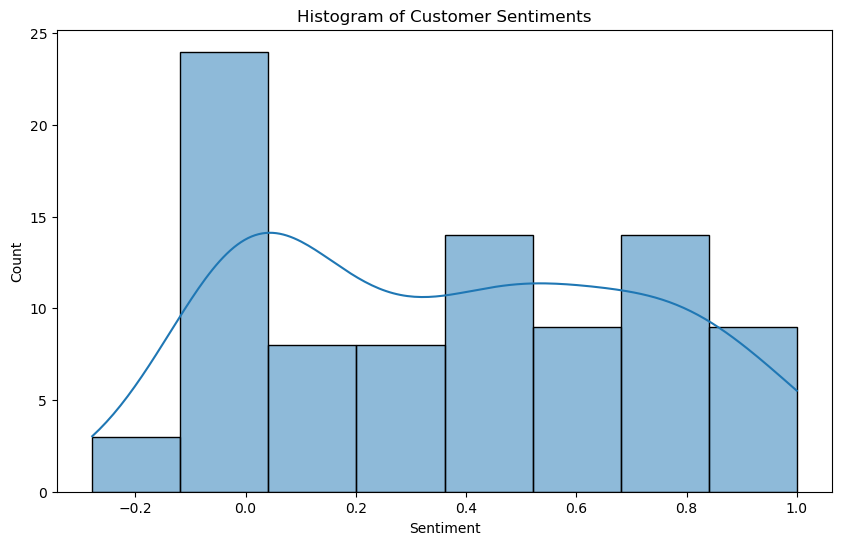

In [75]:
plt.figure(figsize=(10, 6))
sns.histplot(output_df['SENTIMENT'], kde=True)
plt.title('Histogram of Customer Sentiments')
plt.xlabel('Sentiment')
plt.ylabel('Count')
plt.show()

### This shows that there is a spread of sentiment, indicating a variety of customer experiences.

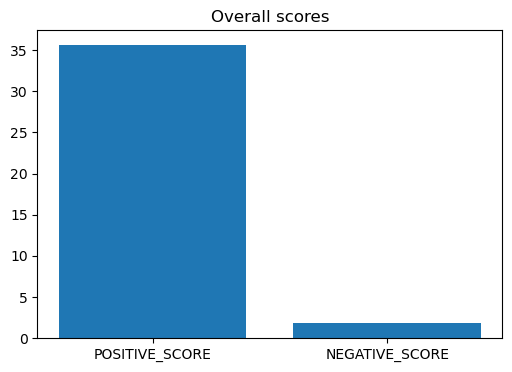

In [76]:
# Sum the positive and negative scores

positive_sum = output_df['POSITIVE_SCORE'].sum()
negative_sum = output_df['NEGATIVE_SCORE'].sum()

# create a bar chart
plt.figure(figsize=(6,4))
plt.title('Overall scores')
plt.bar(['POSITIVE_SCORE', 'NEGATIVE_SCORE'], [positive_sum, negative_sum])
plt.show()

## Overall Sentiment: 

The histogram indicates a predominantly positive sentiment among Starlink customers. The majority of reviews fall within the positive score category, suggesting overall satisfaction with the service.

## Plotting word cloud for Sentiment Scores

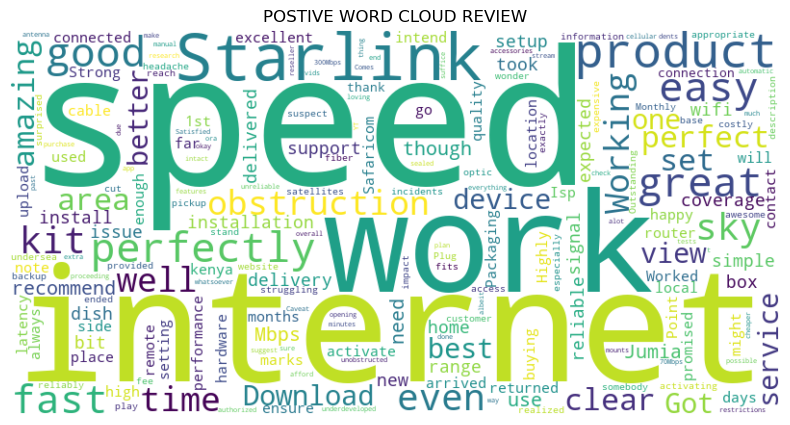

In [86]:
from wordcloud import WordCloud
import matplotlib.pyplot as plt

# filter the reviews with a positive score
positive_reviews = output_df[output_df['POSITIVE_SCORE'] > output_df['NEGATIVE_SCORE']]

# concatenate all positive review text into a single string
positive_text = ' '.join(review for review in positive_reviews['REVIEWS'])

# create a word cloud object with the positive word frequencies and plot it
positive_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(positive_text)
plt.figure(figsize=(10, 5))
plt.imshow(positive_wordcloud, interpolation='bilinear')
plt.axis('off')
plt.title('POSTIVE WORD CLOUD REVIEW')
plt.show()

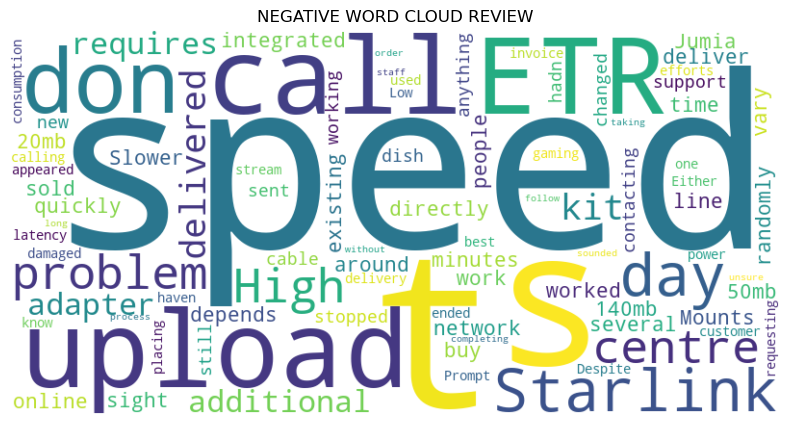

In [85]:
negative_reviews = output_df[output_df['NEGATIVE_SCORE'] > output_df['POSITIVE_SCORE']]

# concatenate all negative review text into a single string
negative_text = ' '.join(review for review in negative_reviews['REVIEWS'])

# create a word cloud object with the negative word frequencies and plot it
negative_wordcloud = WordCloud(width=800, height=400, background_color='white').generate(negative_text)
plt.figure(figsize=(10, 5))
plt.imshow(negative_wordcloud, interpolation='bilinear')
plt.title('NEGATIVE WORD CLOUD REVIEW')
plt.axis('off')
plt.show()

# CONCLUSION: Starlink Customer Sentiment Analysis
### Overall Sentiment:

Based on the analysis of customer reviews, Starlink enjoys a predominantly positive sentiment. The word cloud visualization further reinforces this, with words like "speed," "easy," "perfect," and "great" dominating the positive sentiment.

### Key Strengths:

- Fast and Reliable Internet: Customers are impressed by the speed and reliability of Starlink's service, especially in areas with limited internet access.
- Easy Setup and Installation: The installation process is perceived as straightforward and convenient.
- Excellent Customer Support: Customers appreciate the responsive and helpful support provided by Starlink's team.

### Areas for Improvement:

While the overall sentiment is positive, there are a few areas where Starlink can improve:

- Cost: Some customers find the monthly cost to be relatively high.
- Obstructions: Obstructions like trees and buildings can sometimes interfere with the signal.
